In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from os.path import join

#plt.style.use('seaborn')
#sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 데이터 설명
* TurbID - 발전기 ID
* Day - 날짜
* Tmstamp - 시간
* Wspd - 풍속
* Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
* Etmp - 외부 온도
* Itmp - 터빈 내부 온도
* Ndir - 터빈이 바라보는 방향 각도
* Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름
* Prtv - 무효전력 : 에너지원을 필요로  하지 않는 전력
* Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력 <br><br>

* <b>label: Patv </b>
# 결론적으로 134개 터빈의 201~202일, 즉 2일간의 Patv값을 예측해야 합니다.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
train_data.head()

TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp   Ndir  Pab1  Pab2  Pab3  \
0       1    1   00:00   NaN   NaN    NaN    NaN    NaN   NaN   NaN   NaN   
1       1    1   00:10  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0   
2       1    1   00:20  6.27 -2.18  30.60  41.63  20.91   1.0   1.0   1.0   
3       1    1   00:30  6.42 -0.73  30.52  41.52  20.91   1.0   1.0   1.0   
4       1    1   00:40  6.25  0.89  30.49  41.38  20.91   1.0   1.0   1.0   

   Prtv    Patv  
0   NaN     NaN  
1 -0.25  494.66  
2 -0.24  509.76  
3 -0.26  542.53  
4 -0.23  509.36

In [5]:
train_data.tail(3)

TurbID  Day Tmstamp  Wspd  Wdir  Etmp   Itmp    Ndir  Pab1  Pab2  \
3859197     134  200   23:30  4.23 -0.08  8.74  10.22  172.35  0.01  0.01   
3859198     134  200   23:40  4.36 -6.12  8.64  10.10  172.35  0.01  0.01   
3859199     134  200   23:50  4.79 -3.65  8.53  10.01  168.58  0.01  0.01   

         Pab3    Prtv    Patv  
3859197  0.01 -111.20  220.60  
3859198  0.01 -108.04  222.15  
3859199  0.01 -119.76  264.17

# EDA

array([[<AxesSubplot:title={'center':'TurbID'}>,
        <AxesSubplot:title={'center':'Day'}>,
        <AxesSubplot:title={'center':'Wspd'}>],
       [<AxesSubplot:title={'center':'Wdir'}>,
        <AxesSubplot:title={'center':'Etmp'}>,
        <AxesSubplot:title={'center':'Itmp'}>],
       [<AxesSubplot:title={'center':'Ndir'}>,
        <AxesSubplot:title={'center':'Pab1'}>,
        <AxesSubplot:title={'center':'Pab2'}>],
       [<AxesSubplot:title={'center':'Pab3'}>,
        <AxesSubplot:title={'center':'Prtv'}>,
        <AxesSubplot:title={'center':'Patv'}>]], dtype=object)

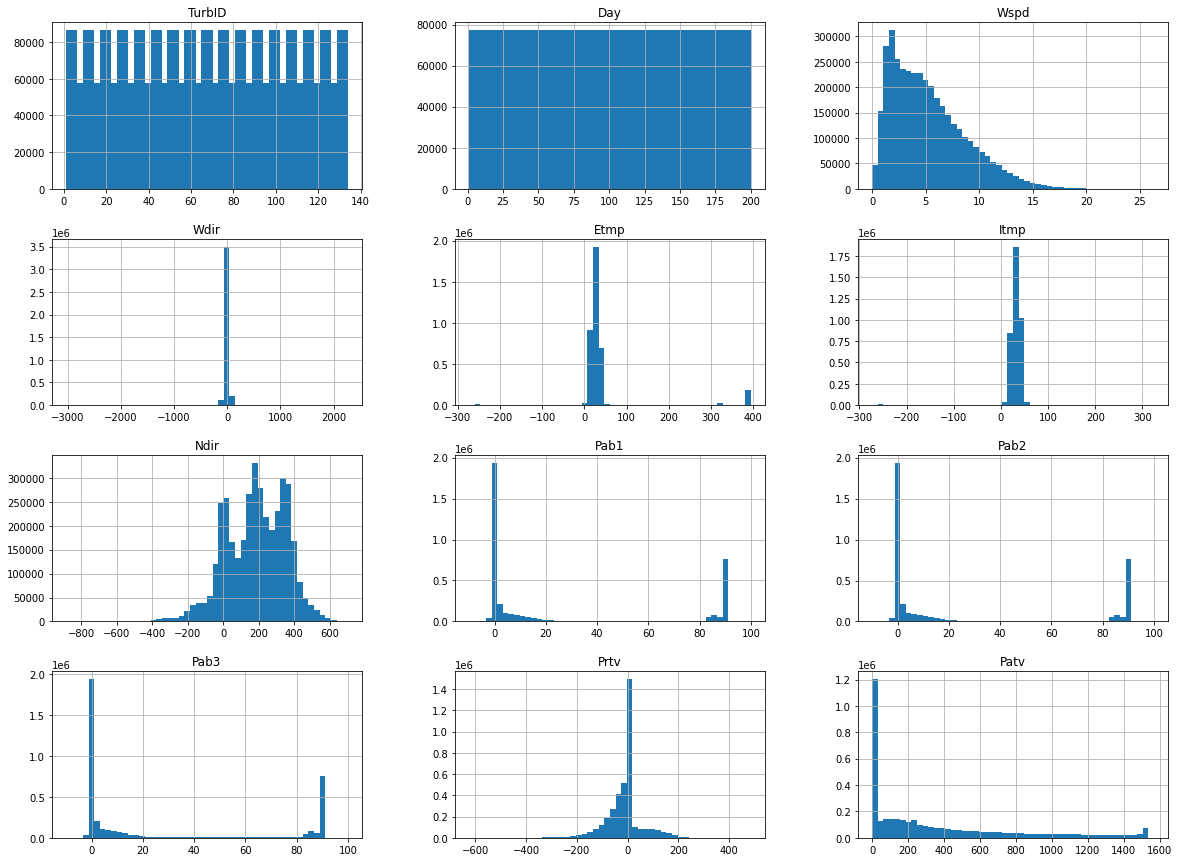

In [6]:
# bins는 막대의 개수
train_data.hist(figsize=(20, 15), bins = 50)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


In [8]:
train_data.describe()

TurbID           Day          Wspd          Wdir          Etmp  \
count  3.859200e+06  3.859200e+06  3.813613e+06  3.813613e+06  3.813613e+06   
mean   6.750000e+01  1.005000e+02  5.237833e+00  1.630704e-01  4.584516e+01   
std    3.868140e+01  5.773431e+01  3.456960e+00  2.991311e+01  8.431290e+01   
min    1.000000e+00  1.000000e+00  0.000000e+00 -3.030460e+03 -2.730300e+02   
25%    3.400000e+01  5.075000e+01  2.430000e+00 -3.840000e+00  2.060000e+01   
50%    6.750000e+01  1.005000e+02  4.580000e+00 -2.500000e-01  2.820000e+01   
75%    1.010000e+02  1.502500e+02  7.290000e+00  3.330000e+00  3.382000e+01   
max    1.340000e+02  2.000000e+02  2.629000e+01  2.266950e+03  3.943300e+02   

               Itmp          Ndir          Pab1          Pab2          Pab3  \
count  3.813613e+06  3.813613e+06  3.813613e+06  3.813613e+06  3.813613e+06   
mean   3.128000e+01  1.847397e+02  2.602276e+01  2.599967e+01  2.598341e+01   
std    1.706048e+01  1.674657e+02  3.824148e+01  3.823116e+01  3.822182e+01   
min   -2.731700e+02 -8.848600e+02 -1.000000e+01 -1.000000e+01 -1.000000e+01   
25%    2.604000e+01  5.189000e+01  1.000000e-02  1.000000e-02  1.000000e-02   
50%    3.271000e+01  1.916700e+02  6.500000e-01  6.400000e-01  6.400000e-01   
75%    3.811000e+01  3.219800e+02  8.013000e+01  7.971000e+01  7.953000e+01   
max    3.242100e+02  7.006200e+02  9.998000e+01  9.998000e+01  9.998000e+01   

               Prtv          Patv  
count  3.813613e+06  3.813613e+06  
mean  -1.484496e+01  3.589438e+02  
std    7.099598e+01  4.259925e+02  
min   -6.249800e+02  0.000000e+00  
25%   -4.085000e+01  0.000000e+00  
50%   -3.100000e-01  1.913000e+02  
75%   -2.000000e-01  5.650100e+02  
max    4.852000e+02  1.567020e+03

In [9]:
train_data.shape

(3859200, 13)

In [10]:
# 결론적으로 134개 터빈의 201~202일, 즉 2일간의 Patv값을 예측해야 합니다.

In [11]:
sample_submission.head(3)

index  TurbID  Day Tmstamp  Wspd  Wdir  Etmp  Itmp  Ndir  Pab1  Pab2  Pab3  \
0      0       1  201   00:00     0     0     0     0     0     0     0     0   
1      1       1  201   00:10     0     0     0     0     0     0     0     0   
2      2       1  201   00:20     0     0     0     0     0     0     0     0   

   Prtv  Patv  
0     0  9999  
1     0  9999  
2     0  9999

In [12]:
    # train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [13]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [19]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 167): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["TurbID", "Day"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y

def make_valid_data(data):
    valid_x, valid_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(167, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            valid_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            valid_tmp = valid_tmp.drop(["TurbID", "Day"], axis = 1)
            
            valid_x.append(np.array(valid_tmp))
            valid_y.append(np.array(label_tmp))
            
    return valid_x, valid_y




In [20]:
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) + 1)

train_x, train_y = make_train_data(train_data)
valid_x, valid_y = make_valid_data(train_data)


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:05<00:00, 26.56it/s]


In [14]:
valid_x

[array([[ 1.000e+00,  1.710e+00,  1.760e+00, ...,  1.000e+00, -2.400e-01,
          2.538e+01],
        [ 2.000e+00,  1.430e+00,  1.540e+00, ...,  1.000e+00, -5.000e-02,
          1.520e+01],
        [ 3.000e+00,  1.490e+00, -6.490e+00, ...,  9.900e-01, -2.600e-01,
          8.090e+00],
        ...,
        [ 1.420e+02,  7.610e+00,  9.370e+00, ...,  1.900e+00, -3.000e-01,
          0.000e+00],
        [ 1.430e+02,  6.130e+00, -9.170e+00, ...,  1.900e+00, -3.000e-01,
          0.000e+00],
        [ 1.440e+02,  4.920e+00, -9.010e+00, ...,  1.900e+00, -3.000e-01,
          0.000e+00]]),
 array([[ 1.00000e+00,  7.65000e+00,  1.24000e+00, ...,  1.00000e+00,
         -2.90000e-01,  9.20190e+02],
        [ 2.00000e+00,  8.45000e+00, -1.40000e-01, ...,  1.00000e+00,
         -2.20000e-01,  1.09859e+03],
        [ 3.00000e+00,  9.07000e+00, -6.00000e-02, ...,  1.00000e+00,
         -2.30000e-01,  1.20073e+03],
        ...,
        [ 1.42000e+02,  1.73000e+00,  4.46000e+01, ...,  1.90000e+00,
  

In [12]:
valid_y

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [21]:
len(train_x)

22244

In [22]:
len(train_y)

22244

In [23]:
len(valid_x)

3752

In [24]:
len(valid_y)

3752

In [18]:
train_data['Tmstamp']

0            1
1            2
2            3
3            4
4            5
          ... 
3859195    140
3859196    141
3859197    142
3859198    143
3859199    144
Name: Tmstamp, Length: 3859200, dtype: int64

In [19]:
train_data.head()

TurbID  Day  Tmstamp  Wspd  Wdir   Etmp   Itmp   Ndir  Pab1  Pab2  Pab3  \
0       1    1        1  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0   
1       1    1        2  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0   
2       1    1        3  6.27 -2.18  30.60  41.63  20.91   1.0   1.0   1.0   
3       1    1        4  6.42 -0.73  30.52  41.52  20.91   1.0   1.0   1.0   
4       1    1        5  6.25  0.89  30.49  41.38  20.91   1.0   1.0   1.0   

   Prtv    Patv  
0 -0.25  494.66  
1 -0.25  494.66  
2 -0.24  509.76  
3 -0.26  542.53  
4 -0.23  509.36

In [25]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

#GPU 자원이 부족한 경우 아래 코드를 이용하세요
'''from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)'''

ModuleNotFoundError: No module named 'tensorflow'

In [21]:
train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y = np.array(train_y)

In [22]:
train_x.shape, train_y.shape

((25996, 720, 11), (25996, 288))

# 모델 학습

In [23]:
model = Sequential()
model.add(GRU(256, input_shape=(train_x[0].shape[0], train_x[0].shape[1])))
model.add(Dense(516, activation='relu'))
model.add(Dense(288, activation = 'relu'))

optimizer = tf.optimizers.RMSprop(0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [24]:
model.fit(train_x, train_y, epochs=10, batch_size=128)

Epoch 1/10
204/204 [==============================] - 9s 37ms/step - loss: 196425.7969 - mae: 334.0929
Epoch 2/10
204/204 [==============================] - 7s 36ms/step - loss: 170089.0938 - mae: 324.9602
Epoch 3/10
204/204 [==============================] - 7s 37ms/step - loss: 162334.0312 - mae: 315.6356
Epoch 4/10
204/204 [==============================] - 7s 36ms/step - loss: 157368.2656 - mae: 309.3179
Epoch 5/10
204/204 [==============================] - 8s 37ms/step - loss: 153225.3750 - mae: 304.2736
Epoch 6/10
204/204 [==============================] - 7s 36ms/step - loss: 148958.0625 - mae: 298.8201
Epoch 7/10
204/204 [==============================] - 7s 36ms/step - loss: 144977.4375 - mae: 293.4858
Epoch 8/10
204/204 [==============================] - 7s 37ms/step - loss: 141399.1094 - mae: 288.6848
Epoch 9/10
204/204 [==============================] - 7s 36ms/step - loss: 137677.3594 - mae: 283.7255
Epoch 10/10
204/204 [==============================] - 7s 37ms/step - los

# 201일, 202일 Patv 추론

In [25]:
test_data_list = [x for x in range(196, 201)] # 196~200 / 날짜에 따라 수정해줘야함.

test_data = train_data[train_data['Day'].isin(test_data_list)]

test_data = test_data.drop(['TurbID', 'Day'], axis=1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])

In [26]:
test_data.shape

(134, 720, 11)

In [27]:
pred = model.predict(test_data)
pred = pred.reshape(-1)

In [28]:
pred

array([196.96523, 202.45152, 218.04356, ..., 314.42932, 315.37875,
       308.53064], dtype=float32)

In [29]:
sample_submission['Patv'] = pred

sample_submission.to_csv('Baseline2.csv', index=False)